## 引言

#### 研究目的
本文参考东吴证券研报《低开高走的收益特征》内容，对A股市场的低开现象进行探索。低开现象在A股市场中是常态，对于股票低开的原因，我们认为主要是A股市场的T+1交易制度。在每个交易日的最开始，现金持有者可以自由买入股票，股票持有者可以自由卖出股票。这种对称性在盘中被T+1制度打破：当日卖出股票的所得资金，可以再次买入股票；而当日买入的股票，当日却无法卖出。这个“想卖不能卖”的卖压，会随着临近收盘而逐渐累积。因此，次日开盘时，只要有一部分卖压通过集合竞价释放出来，股票便会倾向于低开。低开高走现象具备短线交易的潜力，本报告的动机是，尝试进一步挖掘其中的确定性规律，分析“怎样的低开更会高走”。我们给出三个最典型的增强因子：集合竞价成交量、低开幅度、昨日换手率。

#### 研究思路
【1】 对时间周期内每日符合条件的低开股票进行筛选并观察其比例

【2】 设定不同增强因子，对低开股票在增强因子的分布特征及收益率进行统计

#### 研究结论
【1】 平均来讲，低开现象在我存在较为广泛

【2】 集合竞价成交量、低开幅度、与换手率三个增强因子在平均收益率上均对低开现象有着较好的区分效果

#### 研究设置

【1】时间范围：2013.3 ~ 2019.6

【2】股票池：中证500指数成分股

In [1]:
# 风险及免责提示：该策略由聚宽用户在聚宽社区分享，仅供学习交流使用。
# 原文一般包含策略说明，如有疑问请到原文和作者交流讨论。
# 原文网址：https://www.joinquant.com/view/community/detail/815f45ef4cdc156097bb3f199a7b85f6?type=1
# 标题：低开高走的收益特征

from jqdata import *
import numpy as np
import pandas as pd
import warnings  
warnings.filterwarnings('ignore') 

In [2]:
#交易日获取函数
def get_trade_day_list(start_date, end_date):
    date_df = get_price('000001.XSHG', start_date = start_date, end_date = end_date)
    date_list = []
    for item in list(date_df.index):
        item = str(item)
        y = int(item[0:4])
        m = int(item[5:7])
        d = int(item[8:10])
        date_list.append(datetime.date(y,m,d))
    return date_list

In [3]:
trade_day_list = get_trade_day_list(datetime.date(2013,3,27),datetime.date(2019,6,24))

In [ ]:
## 进行新股、St股、涨跌停过滤，返回筛选后的股票
def filter_stock(stockList,date,days=21*3,limit=0):#日频策略加入开盘涨停过滤
    
    #去除上市距beginDate不足3个月的股票
    def delect_stop(stocks,beginDate,n=days):
        stockList=[]
        beginDate = date
        for stock in stocks:
            start_date=get_security_info(stock).start_date
            if start_date<beginDate-datetime.timedelta(days=n):
                stockList.append(stock)
        return stockList
    
    #剔除ST股
    st_data=get_extras('is_st',stockList, count = 1,end_date=date)
    stockList = [stock for stock in stockList if not st_data[stock][0]]

    #新股及退市股票
    stockList=delect_stop(stockList,date)
    
    #剔除开盘涨停股票
    if limit == 1:
        #如果需要收盘涨跌停可以改字段即可
        df = get_price(stockList,end_date=date,fields=['open','high_limit','low_limit'],count=1).iloc[:,0,:]
        df['h_limit']=(df['open']==df['high_limit'])
        df['l_limit']=(df['open']==df['low_limit'])
        stockList = [df.index[i] for i in range(len(df)) if not (df.h_limit[i] or df.l_limit[i])] #过滤涨跌停股票
    return stockList

## 低开股票筛选

为保证交易的可行性，我们特别处理了跌停的情况。我们剔除了不满足“今开/昨收-1>-9.8%”的样本，即在低开样本中，我们只会买入开盘跌幅小于9.8%的股票，测算范围为中证500指数的成分股，时间跨度从2013年3月27日至2019年6月24日。在筛选后我们统计了符合条件的低开样本，观察图像可知在几年内低开现象在我国A股市场中普遍存在，平均比例约为45%至50%。

In [5]:
#获取指数低开样本
def get_low_start_stock(trade_day_list, stock_index, low_start_rate = -0.098):
    low_start_dict = {}
    primary_stock_list = get_index_stocks(stock_index)
    for day in trade_day_list[1:]:
        stock_list = filter_stock(primary_stock_list, day, limit = 1)
        new_stock_list = []
        location = trade_day_list.index(day)
        for item in stock_list:
            price_df = get_price(item, start_date = trade_day_list[location - 1], end_date = day, fields = ['open', 'close'])
            test_rate = (price_df.loc[day, 'open'] / price_df.loc[trade_day_list[location - 1], 'close']) - 1
            if 0 > test_rate > low_start_rate:
                new_stock_list.append(item)
        new_stock_list.append(len(new_stock_list) / len(stock_list))
        low_start_dict[day] = new_stock_list
    return low_start_dict

In [46]:
low_start_dict = get_low_start_stock(trade_day_list, '000905.XSHG')

In [49]:
#将计算出来的每日股票池进行存储
#使用pickle模块将数据对象保存到文件
import pickle
pkl_file = open('low_start.pkl', 'wb')
pickle.dump(low_start_dict, pkl_file, 0)
pkl_file.close()

In [6]:
#读取计算出来的回归用因子值
import pickle
primary_pkl_file = open('low_start.pkl', 'rb')
low_start_dict = pickle.load(primary_pkl_file)
primary_pkl_file.close()

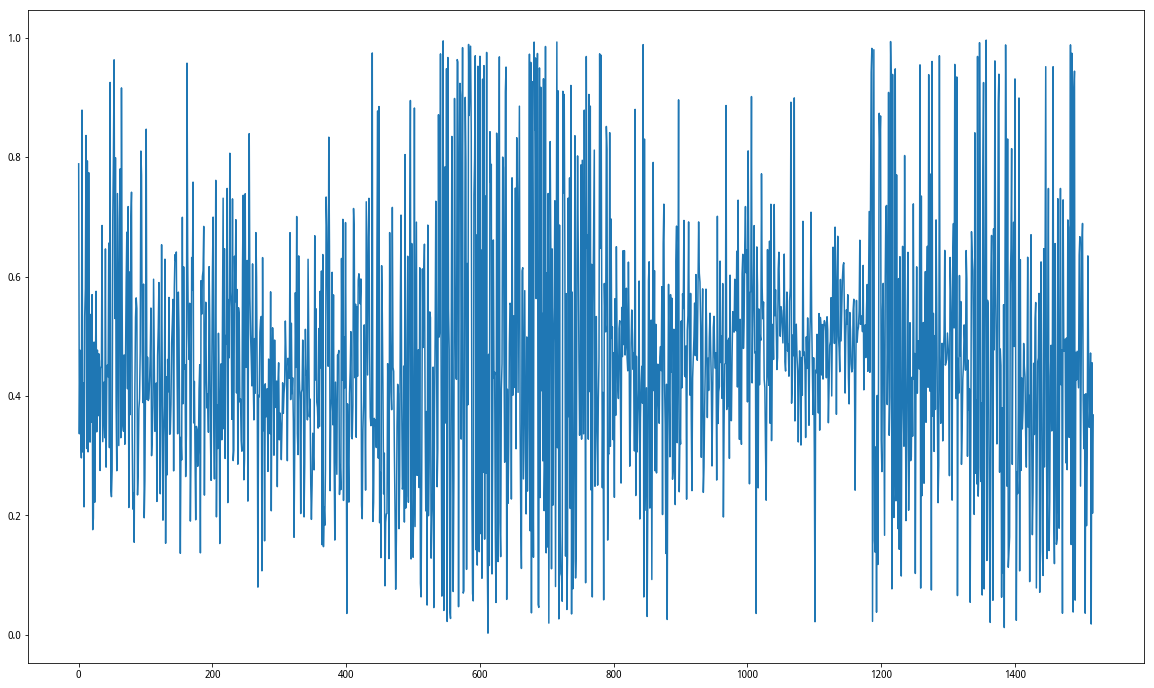

In [20]:
#获取时间周期内低开现象比例
key_list = low_start_dict.keys()
rate_df = pd.DataFrame()
rate_list = []
for item in key_list:
    rate_list.append(low_start_dict[item][-1])
rate_df['rate'] = rate_list
rate_df['rate'].plot(figsize = (20,12))

## 增强因子——集合竞价成交量

对于每只低开的样本股，将其当日集合竞价成交量，与过去60个交易日的集合竞价成交量序列作纵向比较，计算当日水平在近期历史中的分位数P（0≤P≤1）。将每日低开的股票，按P值从低到高分为十组，P值从0到0.1为第0组，P值从0.1到0.2为第1组，以此类推。下图给出了各组样本的平均收益，呈现明显的单调性。一个符合直觉的图景是：集合竞价成交量越大，则市场对于低开的分歧度越大，越易出现反弹。

In [163]:
#获取日内收益——集合竞价成交量
def get_volume_return(stock_dict, time_period):
    keys_list = list(stock_dict.keys())
    volume_df = pd.DataFrame()
    volume_df['return_rate'] = zeros(10)
    volume_df['count'] = zeros(10)
    trade_days_list = get_trade_day_list(datetime.date(2012,12,3),datetime.date(2019,6,24))
    for day in keys_list:
        stock_list = stock_dict[day]
        loc_day = trade_days_list.index(day)
        loc_startday = loc_day - time_period
        start_day = trade_days_list[loc_startday]
        for stock in stock_list[:-1]:
            stock_df = get_price(stock, start_date = start_day, end_date = day, fields = ['open', 'close', 'volume'])
            stock_volume = stock_df.loc[stock_df.index[-1], 'volume']
            stock_return = (stock_df.loc[stock_df.index[-1], 'close'] / stock_df.loc[stock_df.index[-1], 'open']) - 1
            pct_list = []
            for number in list(range(0,10)):
                pct_list.append(np.percentile(stock_df['volume'][:-1] , 10 * (number + 1)))
            for item in pct_list:
                if stock_volume < item :
                    location = pct_list.index(item)
                    volume_df.loc[location,'count'] = volume_df.loc[location,'count'] + 1
                    volume_df.loc[location,'return_rate'] = volume_df.loc[location,'return_rate'] + stock_return
                    break
    volume_df['return_rate'] = volume_df['return_rate'] / volume_df['count']
    return volume_df

In [143]:
volume_df = get_volume_return(low_start_dict, 60)

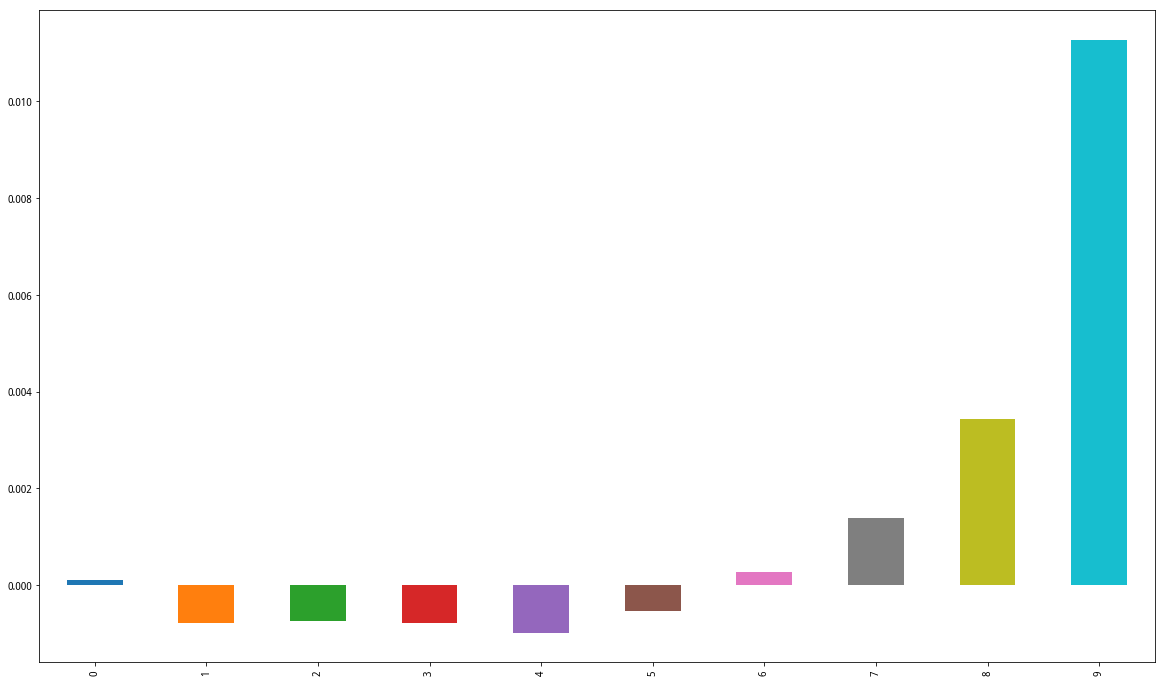

In [149]:
##各组日内收益率
volume_df['return_rate'].plot(kind = 'bar', figsize = (20,12))

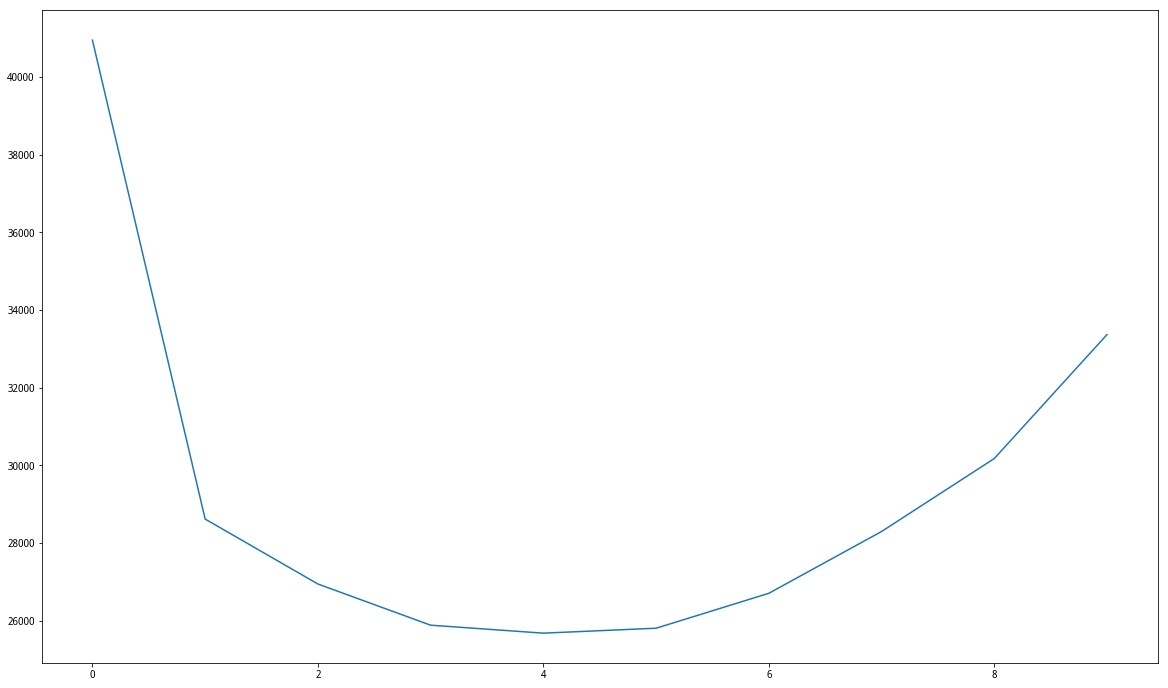

In [148]:
#各组数量
volume_df['count'].plot(figsize = (20,12))

## 增强因子——低开幅度

类比于乒乓球落地的弹性过程，我们可以猜想，高走幅度可能与低开幅度存在正相关。为了验证这一想法，我们将每日低开的股票，按照低开的幅度，从小到大分为十组，如下图所示，样本收益的单调性同样显著。

In [227]:
#获取日内收益——低开幅度
def get_low_start_return(stock_dict):
    keys_list = list(stock_dict.keys())
    low_start_return_df = pd.DataFrame()
    low_start_return_df['return_rate'] = zeros(10)
    low_start_return_df['count'] = zeros(10)
    trade_days_list = get_trade_day_list(datetime.date(2012,12,3),datetime.date(2019,6,24))
    for day in keys_list:
        stock_list = stock_dict[day]
        loc_day = trade_days_list.index(day)
        loc_startday = loc_day - 1
        start_day = trade_days_list[loc_startday]
        low_start_df = pd.DataFrame()
        low_start_list = []
        return_list = []
        for stock in stock_list[:-1]:
            stock_df = get_price(stock, start_date = start_day, end_date = day, fields = ['open', 'close'])
            stock_low_start = -(stock_df.loc[stock_df.index[-1], 'open'] / stock_df.loc[stock_df.index[0], 'close'])
            stock_return = (stock_df.loc[stock_df.index[-1], 'close'] / stock_df.loc[stock_df.index[-1], 'open']) - 1
            low_start_list.append(stock_low_start)
            return_list.append(stock_return)
        low_start_df['low_start'] = low_start_list
        low_start_df['returns'] = return_list
        pct_list = []
        for number in list(range(0,10)):
            pct_list.append(np.percentile(low_start_df['low_start'], 10 * (number + 1)))
        for low_start in low_start_list:
            index = low_start_df[(low_start_df['low_start'] == low_start)].index.tolist()[0]
            returns = low_start_df.loc[index, 'returns']
            for item in pct_list:
                if low_start < item :
                    location = pct_list.index(item)
                    low_start_return_df.loc[location,'count'] = low_start_return_df.loc[location,'count'] + 1
                    low_start_return_df.loc[location,'return_rate'] = low_start_return_df.loc[location,'return_rate'] + returns
                    break
    low_start_return_df['return_rate'] = low_start_return_df['return_rate'] / low_start_return_df['count']
    return low_start_return_df

In [231]:
low_start_return_df = get_low_start_return(low_start_dict)

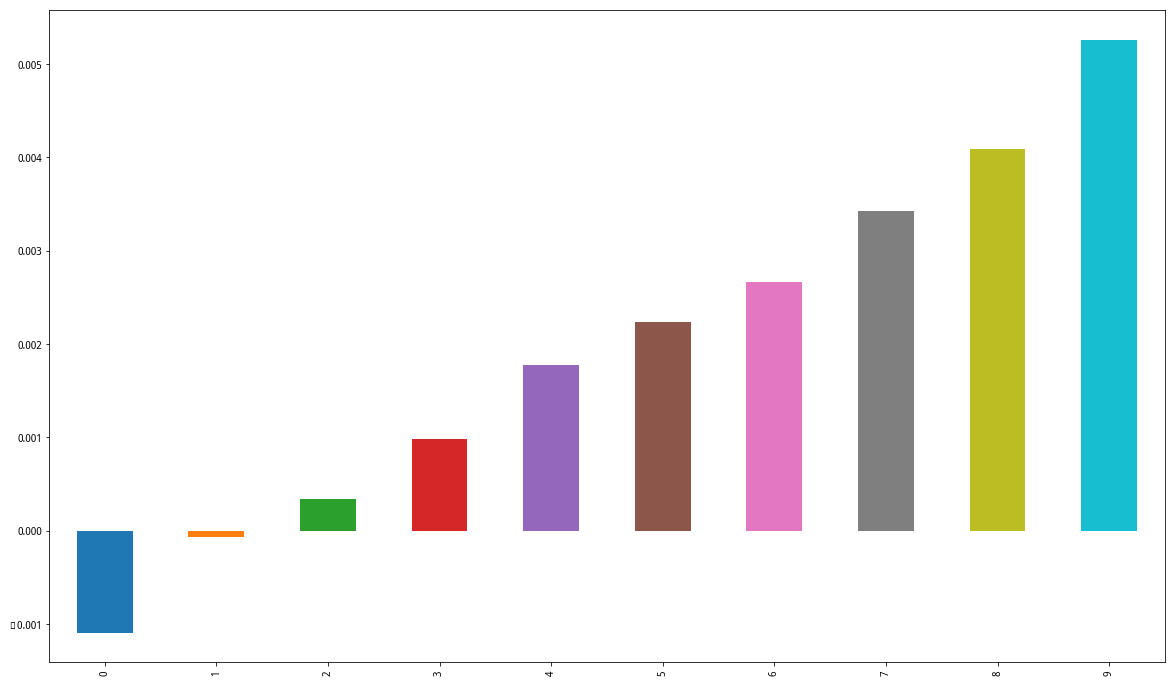

In [232]:
#各组日内收益率
low_start_return_df['return_rate'].plot(kind = 'bar', figsize = (20,12))

## 增强因子——昨日换手率

昨日换手率也有一定的分组能力。对于每只低开的样本股，将其昨日换手率，与过去60个交易日的换手率作纵向比较，得到分位数Q（0≤Q≤1）。将每日低开的股票，按Q值从低到高分为十组，结果如下图所示。我们偏向于认为，如果昨日换手率太大，则存在对低开的提前反应，低开之后反弹的可能性会较大。

In [7]:
#获取日内收益——昨日换手率
def get_turnover_return(stock_dict, time_period):
    keys_list = list(stock_dict.keys())
    turnover_return_df = pd.DataFrame()
    turnover_return_df['return_rate'] = zeros(10)
    turnover_return_df['count'] = zeros(10)
    trade_days_list = get_trade_day_list(datetime.date(2012,12,3),datetime.date(2019,6,24))
    turnover_df = pd.DataFrame()
    turnover_list = []
    return_list = []
    for day in keys_list:
        print(day)
        stock_list = stock_dict[day]
        loc_day = trade_days_list.index(day)
        loc_startday = loc_day - time_period
        start_day = trade_days_list[loc_startday]
        date_list = trade_days_list[loc_startday : (loc_day + 1)]
        for stock in stock_list[:-1]:
            daily_turnover_list = []
            stock_df = get_price(stock, start_date = start_day, end_date = day, fields = ['open', 'close', 'volume'])
            stock_return = (stock_df.loc[stock_df.index[-1], 'close'] / stock_df.loc[stock_df.index[-1], 'open']) - 1
            for days in date_list:
                q = query(valuation).filter(valuation.code == stock)
                df = get_fundamentals(q, str(days))
                if len(df.index) == 0:
                    continue
                turnover_rate = stock_df.loc[days, 'volume'] / df.loc[0,'circulating_cap']
                daily_turnover_list.append(turnover_rate)
            target_turnover = daily_turnover_list[-1]
            daily_turnover_list.sort()
            if len(daily_turnover_list) == 0:
                continue
            target_rate = daily_turnover_list.index(target_turnover) / len(daily_turnover_list)
            turnover_list.append(target_rate)
            return_list.append(stock_return)
    turnover_df['turnover'] = turnover_list
    turnover_df['returns'] = return_list
    pct_list = []
    for number in list(range(0,10)):
        pct_list.append(np.percentile(turnover_df['turnover'], 10 * (number + 1)))
    for turnover in turnover_list:
        index = turnover_df[(turnover_df['turnover'] == turnover)].index.tolist()[0]
        returns = turnover_df.loc[index, 'returns']
        for item in pct_list:
            if turnover < item :
                location = pct_list.index(item)
                turnover_return_df.loc[location,'count'] = turnover_return_df.loc[location,'count'] + 1
                turnover_return_df.loc[location,'return_rate'] = turnover_return_df.loc[location,'return_rate'] + returns
                break
    turnover_return_df['return_rate'] = turnover_return_df['return_rate'] / turnover_return_df['count']
    return turnover_return_df

In [ ]:
turnover_return_df = get_turnover_return(low_start_dict, 60)

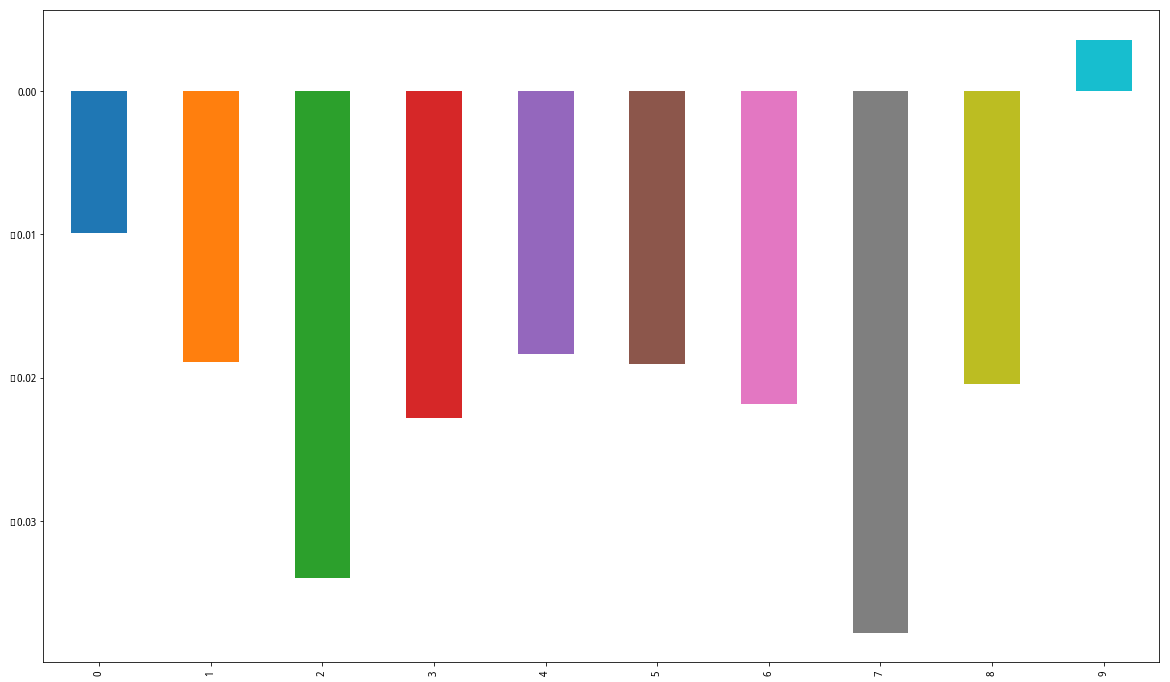

In [9]:
#各组日内收益率
turnover_return_df['return_rate'].plot(kind = 'bar', figsize = (20,12))

In [11]:
turnover_return_df

,return_rate,count
0,-0.009935,27892.0
1,-0.018908,26968.0
2,-0.033970,33851.0
3,-0.022841,27315.0
4,-0.018371,30760.0
5,-0.019049,30155.0
6,-0.021820,31191.0
7,-0.037797,28142.0
8,-0.020443,29975.0
9,0.003581,27229.0
